In [1]:
import numpy as np
import scipy.stats, scipy.special, scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(42)
n_samples = 5000
sample_size = 250
n_samples = 5
sample_size = 100
var_1 = 1.
var_2 = 10.
mu_real = 0.
p_real = 0.7

cuttoff =100
delta = 0.01

In [3]:
"""Gerneate array of cumulative density"""
total_cdf = lambda x: (p_real)*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_1) + (1.-p_real)*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_2)
x_vals = np.arange(-1.*cuttoff,1.*cuttoff,0.1)
x_vals = np.array(x_vals)
total_cdf_vals = [total_cdf(x) for x in x_vals]
total_cdf_vals = np.array(total_cdf_vals)

In [4]:
"""Generate random samples from distribution"""
def gen_rand_dist(size=1, p=p_real, mu=mu_real):
    var_1 = 1.
    var_2 = 10.
    total_cdf = lambda x: (p_real)*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_1) + (1.-p_real)*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_2)
    x_vals = np.arange(-1.*cuttoff,1.*cuttoff,0.1)
    x_vals = np.array(x_vals)
    total_cdf_vals = [total_cdf(x) for x in x_vals]
    total_cdf_vals = np.array(total_cdf_vals)

    rand_ps = np.random.uniform(low=0.0, high=1.0, size=size,)
    rand_xs = np.zeros(size)
    for i, rand_p in enumerate(rand_ps):
        rand_p_list = np.full(shape=total_cdf_vals.size, fill_value=rand_p)
        id_rand_x = np.abs(rand_p_list - total_cdf_vals).argmin()
        #print(x_vals.flat[id_rand_x])
        rand_xs[i] = x_vals.flat[id_rand_x]
    
    #print(rand_xs)
    return rand_xs

def lhood(input_sample, mu, p):
    lhood = 1.
    #print(lhood)
    
    sample_prob = p*scipy.stats.norm.pdf(input_sample, loc=mu, scale=var_1) + (1-p)*scipy.stats.norm.pdf(input_sample, loc=mu, scale=var_2)
    lhood = sample_prob.prod()
    #print(lhood)
    
    return lhood
"""ALWAYS US -LOG LIKELYHOOD"""
"""Numerically more efficient!!!"""
def neg_log_lhood(input_sample, mu, p):
    neg_log_lhood = 0.
    
    
    log_sample_prob = np.log( p*scipy.stats.norm.pdf(input_sample, loc=mu, scale=var_1) + (1.-p)*scipy.stats.norm.pdf(input_sample, loc=mu, scale=var_2) )
    neg_log_lhood = -1. * (log_sample_prob.sum())
    
    return neg_log_lhood

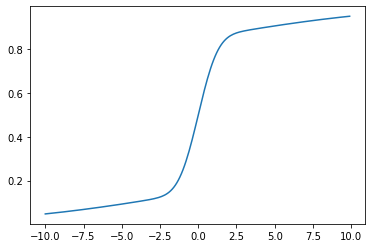

In [5]:
x_vals = np.arange(-10,10,0.1)
#gauss_vals = [scipy.stats.norm.pdf(x, loc=mu_real, scale=var_2) for x in x_vals]
#gauss_vals = [scipy.stats.norm.pdf(x, loc=mu_real, scale=var_2) for x in x_vals]
gauss_cum_vals = [p_real*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_1) + (1-p_real)*scipy.stats.norm.cdf(x, loc=mu_real, scale=var_2) for x in x_vals]
plt.plot(x_vals, gauss_cum_vals)

In [6]:
#samples
samples = np.zeros((n_samples, sample_size))

for i in range(n_samples):
    samples[i] = gen_rand_dist(size=sample_size)


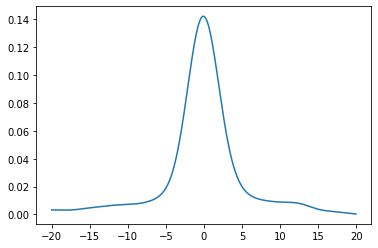

In [7]:
density = scipy.stats.gaussian_kde(samples[0])
samples_xs = np.arange(-20,20,0.01)
plt.plot(samples_xs, density(samples_xs))


In [8]:
mu_mls = np.zeros(n_samples)
p_mls = np.zeros(n_samples)
mu_0 = 0.
p_0 = 0.5
for i, sample in enumerate(samples):
    print(i)
    """Numerically inefficent, often gives ln(0) error -> use neg_log_lhood()"""
    neg_log_lhood_mu = lambda mu:  -1.*np.log(lhood(sample, mu, p_0))
    neg_log_lhood_p = lambda p:  -1.*np.log(lhood(sample, mu_0, p))
    neg_lhood_mu = lambda mu:  -1.*(lhood(sample, mu, p_0))
    neg_lhood_p = lambda p:  -1.*(lhood(sample, mu_0, p))
    
    """
    #analytical rearranging yields
    def special_neg_log_lhood(sample, mu, p):
        ln_lhood = 0.
        inv_delta_var = (var_1*var_2)/(var_1 - var_2)
        neg_lhood = 0.
        for val in sample:
            dev2 = (val - mu)*(val - mu)
            exp_pot = 0.5*dev2*inv_delta_var
            ln_l_i = ( np.log(p) - 0.5*np.log(var_1) - (0.5*dev2)/(var_1) ) * np.log(1. +  np.sqrt(var_1/var_2) * (1-p)/p * np.exp(-exp_pot))
            neg_lhood += ln_l_i
            
        return (-1*ln_lhood)
    """        
    
    """Bounds for parameters μ and p"""
    par_bounds = ((-10.,10.),(0.01,0.99))
    #par_bounds = ((0.,1.),(-10.,10.))
    
    
    def arr_neg_log_lhood(par, sample):
        result = neg_log_lhood(sample, par[0], par[1])
        return result
    
    """find maximum likelyhood parameters μ and p"""
    ml = scipy.optimize.minimize(lambda par: arr_neg_log_lhood(par, sample), x0=[mu_0, p_0], bounds=par_bounds)
    
    
    #def arr_lhood(par, sample):
    #    result = -(lhood(sample, par[0], par[1]))
    #    return result
    
    """find maximum likelyhood parameters μ and p"""
    #ml = scipy.optimize.minimize(lambda par: arr_lhood(par, sample), x0=[mu_0, p_0], bounds=par_bounds)
    
    
    """
    def arr_special_neg_log_lhood(par):
        result = special_neg_log_lhood(sample, par[0], par[1])
        return result
    ml = scipy.optimize.minimize(lambda par: arr_special_neg_log_lhood(par), x0=[mu_0, p_0], bounds=par_bounds)
    """
    
    print(ml.x)
    mu_mls[i] = ml.x[0]
    p_mls[i] = ml.x[1]

0
[-0.08272181  0.65797368]
1
[0.16794954 0.61470672]
2
[-0.16251417  0.73010591]
3
[-0.13662182  0.70753231]
4
[0.1995859  0.66374133]
5
[0.07066209 0.70174989]
6
[-0.03451503  0.69392353]
7
[0.09729847 0.72217198]
8
[0.10877149 0.68963213]
9
[-0.07252803  0.70979887]
10
[0.07541517 0.67845821]
11
[0.03607402 0.68913792]
12
[-0.03045027  0.71327344]
13
[0.14156106 0.73339359]
14
[-0.10744753  0.70976112]
15
[-0.04605156  0.69187104]
16
[0.02830911 0.71813856]
17
[-0.07429646  0.71350264]
18
[0.01258566 0.72379412]
19
[-0.11095593  0.68936653]
20
[-0.00142959  0.70374416]
21
[-0.09978155  0.70116991]
22
[0.00503819 0.68769946]
23
[-0.00619678  0.68516656]
24
[-0.04920754  0.70651104]
25
[0.0058407 0.7001036]
26
[0.04243498 0.70031484]
27
[-0.14840631  0.66485425]
28
[-0.04518723  0.70841552]
29
[-0.1354766   0.71274942]
30
[0.03190301 0.69198431]
31
[-0.1707818   0.68178509]
32
[-0.07816009  0.73258386]
33
[-0.03072954  0.7058058 ]
34
[-0.0521747   0.74949503]
35
[-0.01757791  0.718069

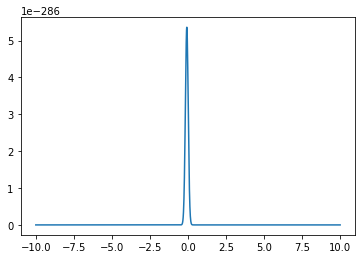

In [9]:
mu_vals = np.arange(-10, 10, 0.01)
p_vals = np.arange(0.001, 1., 0.001)

lhood_mu_vals = np.array([lhood(samples[0], mu_val, p_0) for mu_val in mu_vals])
lhood_p_vals = np.array([lhood(samples[0], mu_0, p_val) for p_val in p_vals])

#likelyhood of μ
plt.plot(mu_vals, lhood_mu_vals)

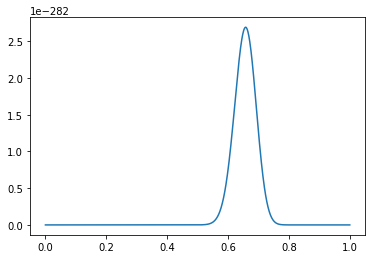

In [10]:
#likelyhood of p
plt.plot(p_vals, lhood_p_vals)

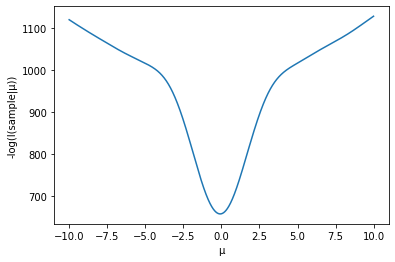

In [11]:
neg_log_lhood_mu_vals = np.array([neg_log_lhood(samples[0], mu_val, p_0) for mu_val in mu_vals])
neg_log_lhood_p_vals = np.array([neg_log_lhood(samples[0], mu_0, p_val) for p_val in p_vals])
#negative loglikelyhood of μ
plt.xlabel("μ")
plt.ylabel("-log(l(sample|μ))")
plt.plot(mu_vals, neg_log_lhood_mu_vals)


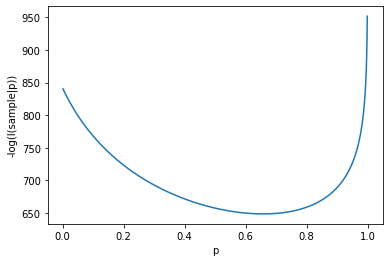

In [12]:
#negative log likelyhood of p
plt.xlabel("p")
plt.ylabel("-log(l(sample|p))")
plt.plot(p_vals, neg_log_lhood_p_vals)

In [13]:
ml_df = pd.DataFrame({"μ" : mu_mls, "p" : p_mls})
ml_df.describe()

,μ,p
count,50.000000,50.000000
mean,-0.010518,0.700101
std,0.085384,0.028773
min,-0.170782,0.591131
25%,-0.071774,0.689195
50%,-0.003813,0.703621
75%,0.039526,0.713464
max,0.199586,0.751950


In [14]:
"""
scipy.optim.minimize has trouble minimizing the function
but plot clearly indicates minimum at 0.7!
Mean fluctuates around 0. as expected
"""

'\nscipy.optim.minimize has trouble minimizing the function\nbut plot clearly indicates minimum at 0.7!\nMean fluctuates around 0. as expected\n'